# Fine-Tuning Legal-BERT:

Este notebook representa a versão definitiva e profissional do pipeline de NER, incorporando:
1.  **Otimização Bayesiana de Hiperparâmetros** (Optuna).
2.  **Diagnóstico Avançado de Erros** (Matriz de Confusão).
3.  **Monitoramento Completo**: Curvas de Aprendizado e Métricas de Negócio (F1).
4.  **MLOps Completo**: Versionamento e Registro de Modelo no MLflow (Staging/Production).
5.  **Simulação de Produção**: Wrapper para inferência em contratos longos.
6.  **Bônus Sênior**: Quantização Dinâmica (INT8) para redução de custos.

**Stack**: `transformers`, `optuna`, `mlflow`, `sklearn`.

In [1]:
# Instalação de TODAS as dependências necessárias
#!pip install transformers datasets seqeval accelerate evaluate torch pandas mlflow matplotlib seaborn optuna scikit-learn

In [2]:
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification, pipeline
import evaluate
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import random
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configuração Inicial
mlflow.set_experiment("Legal-BERT-NER-Advanced")
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    print(f"✅ GPU Detectada: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ GPU não detectada.")

✅ GPU Detectada: NVIDIA GeForce RTX 3050 Laptop GPU


## 1. Engenharia de Dados (Pipeline)

In [3]:
# Definição de Labels e IDs
target_categories = ['Termination Date', 'Governing Law', 'Document Name']
label_list = ['O']
for cat in target_categories:
    label_list.append(f'B-{cat}')
    label_list.append(f'I-{cat}')

id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}
O_LABEL_ID = label2id['O']

# Carregamento e Preparação
raw_dataset = load_dataset("TheAtticusProject/cuad-qa", split='train')
filtered_dataset = raw_dataset.filter(lambda x: any(cat in x['question'] for cat in target_categories))
document_split = filtered_dataset.train_test_split(test_size=0.1, seed=SEED)

# Tokenização
model_checkpoint = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_in_batches(examples):
    tokenized_inputs = tokenizer(
        examples["context"],
        truncation=True,
        max_length=512,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )
    labels = []
    sample_map = tokenized_inputs.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_inputs.pop("offset_mapping")

    for i, offsets in enumerate(offset_mapping):
        sample_index = sample_map[i]
        answers = examples["answers"][sample_index]
        question = examples["question"][sample_index]
        current_category = next((cat for cat in target_categories if cat in question), None)
        
        chunk_labels = [O_LABEL_ID] * len(tokenized_inputs["input_ids"][i])
        ctx_len = len(examples["context"][sample_index])
        char_labels = ["O"] * ctx_len

        if current_category and answers['text']:
            for start, text in zip(answers['answer_start'], answers['text']):
                end = start + len(text)
                if start < ctx_len:
                    char_labels[start] = f"B-{current_category}"
                    for k in range(start + 1, min(end, ctx_len)):
                        char_labels[k] = f"I-{current_category}"
        
        for idx, (start, end) in enumerate(offsets):
            if start == end: chunk_labels[idx] = -100
            elif start < len(char_labels):
                token_label_str = char_labels[start]
                if token_label_str in label2id: chunk_labels[idx] = label2id[token_label_str]
        labels.append(chunk_labels)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

train_tokenized = document_split["train"].map(tokenize_in_batches, batched=True, remove_columns=document_split["train"].column_names)
test_tokenized = document_split["test"].map(tokenize_in_batches, batched=True, remove_columns=document_split["test"].column_names)

# Downsampling
def downsample(dataset, prob=0.3):
    return dataset.filter(lambda x: any(l != O_LABEL_ID and l != -100 for l in x['labels']) or random.random() < prob)

train_balanced = downsample(train_tokenized)
print(f"Dados de Treino Balanceados: {len(train_balanced)}")

c:\Users\flavi\AppData\Local\Programs\Python\Python310\lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for TheAtticusProject/cuad-qa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/TheAtticusProject/cuad-qa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Dados de Treino Balanceados: 7231


## 2. Otimização de Hiperparâmetros (Optuna)

In [4]:
metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

def model_init():
    return AutoModelForTokenClassification.from_pretrained(
        model_checkpoint, num_labels=len(label_list), id2label=id2label, label2id=label2id
    )

# Definindo o espaço de busca manualmente para evitar OOM (limitando batch size)
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 4),
        "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8]), 
    }

args = TrainingArguments(
    output_dir="./legal-bert-ner-optuna",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8, # Start small safe
    per_device_eval_batch_size=8,  # Start small safe
    gradient_accumulation_steps=2, # Compensate for small batch size
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=train_balanced,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print("Iniciando busca de hiperparâmetros (Optuna)... ")
best_run = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=my_hp_space, # Usar o espaço customizado
    n_trials=5 
)

print("\n🔥 Melhores Parâmetros Encontrados:")
print(best_run.hyperparameters)

c:\Users\flavi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\flavi\AppData\Local\Programs\Python\Python310\lib\site-packages\accelerate\accelerator.py:479: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of BertForTokenClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-12-10 06:59:21,568] A new study created in memory with name: no-name-0187e73e-ebd0-4c19-b737-7a53d4f8bde2


Iniciando busca de hiperparâmetros (Optuna)... 


Some weights of BertForTokenClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1808 [00:00<?, ?it/s]

{'loss': 0.4294, 'grad_norm': 0.07684323936700821, 'learning_rate': 1.1940311341293788e-05, 'epoch': 0.06}
{'loss': 0.0345, 'grad_norm': 0.11928731948137283, 'learning_rate': 1.1601097950916124e-05, 'epoch': 0.11}
{'loss': 0.0353, 'grad_norm': 0.5108126997947693, 'learning_rate': 1.1261884560538458e-05, 'epoch': 0.17}
{'loss': 0.0258, 'grad_norm': 0.03054306097328663, 'learning_rate': 1.0922671170160795e-05, 'epoch': 0.22}
{'loss': 0.0197, 'grad_norm': 0.1960473656654358, 'learning_rate': 1.058345777978313e-05, 'epoch': 0.28}
{'loss': 0.0107, 'grad_norm': 0.46964213252067566, 'learning_rate': 1.0244244389405465e-05, 'epoch': 0.33}
{'loss': 0.0161, 'grad_norm': 0.48434823751449585, 'learning_rate': 9.9050309990278e-06, 'epoch': 0.39}
{'loss': 0.0153, 'grad_norm': 0.08289580047130585, 'learning_rate': 9.565817608650136e-06, 'epoch': 0.44}
{'loss': 0.0105, 'grad_norm': 0.03218130022287369, 'learning_rate': 9.22660421827247e-06, 'epoch': 0.5}
{'loss': 0.0067, 'grad_norm': 0.049804590642452

  0%|          | 0/324 [00:00<?, ?it/s]

{'eval_loss': 0.005043718032538891, 'eval_precision': 0.10552763819095477, 'eval_recall': 0.19811320754716982, 'eval_f1': 0.1377049180327869, 'eval_accuracy': 0.9978159521443344, 'eval_runtime': 39.5136, 'eval_samples_per_second': 65.446, 'eval_steps_per_second': 8.2, 'epoch': 1.0}
{'loss': 0.0082, 'grad_norm': 0.30282479524612427, 'learning_rate': 5.834470314495828e-06, 'epoch': 1.05}
{'loss': 0.0083, 'grad_norm': 0.061875276267528534, 'learning_rate': 5.495256924118163e-06, 'epoch': 1.11}
{'loss': 0.0065, 'grad_norm': 0.01727207563817501, 'learning_rate': 5.156043533740499e-06, 'epoch': 1.16}
{'loss': 0.0053, 'grad_norm': 0.15257719159126282, 'learning_rate': 4.816830143362835e-06, 'epoch': 1.22}
{'loss': 0.0085, 'grad_norm': 0.07326113432645798, 'learning_rate': 4.47761675298517e-06, 'epoch': 1.27}
{'loss': 0.0052, 'grad_norm': 0.04980377107858658, 'learning_rate': 4.138403362607506e-06, 'epoch': 1.33}
{'loss': 0.0092, 'grad_norm': 0.04002000018954277, 'learning_rate': 3.79918997222

  0%|          | 0/324 [00:00<?, ?it/s]

[I 2025-12-10 07:11:57,227] Trial 0 finished with value: 1.7986087678037297 and parameters: {'learning_rate': 1.2265956196056345e-05, 'num_train_epochs': 2, 'seed': 36, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 1.7986087678037297.


{'eval_loss': 0.0045846449211239815, 'eval_precision': 0.21212121212121213, 'eval_recall': 0.330188679245283, 'eval_f1': 0.25830258302583026, 'eval_accuracy': 0.9979962934114045, 'eval_runtime': 39.3104, 'eval_samples_per_second': 65.784, 'eval_steps_per_second': 8.242, 'epoch': 2.0}
{'train_runtime': 754.751, 'train_samples_per_second': 19.161, 'train_steps_per_second': 2.395, 'train_loss': 0.022361719820120956, 'epoch': 2.0}


c:\Users\flavi\AppData\Local\Programs\Python\Python310\lib\site-packages\accelerate\accelerator.py:479: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of BertForTokenClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1808 [00:00<?, ?it/s]

{'loss': 0.2338, 'grad_norm': 0.08528781682252884, 'learning_rate': 2.890719382792822e-05, 'epoch': 0.06}
{'loss': 0.0332, 'grad_norm': 0.2719753384590149, 'learning_rate': 2.80859667305439e-05, 'epoch': 0.11}
{'loss': 0.0229, 'grad_norm': 0.1868785321712494, 'learning_rate': 2.7264739633159574e-05, 'epoch': 0.17}
{'loss': 0.0173, 'grad_norm': 0.05612631142139435, 'learning_rate': 2.644351253577525e-05, 'epoch': 0.22}
{'loss': 0.0155, 'grad_norm': 0.3625093698501587, 'learning_rate': 2.5622285438390924e-05, 'epoch': 0.28}
{'loss': 0.0129, 'grad_norm': 0.03128524124622345, 'learning_rate': 2.4801058341006602e-05, 'epoch': 0.33}
{'loss': 0.0149, 'grad_norm': 0.011505458503961563, 'learning_rate': 2.3979831243622276e-05, 'epoch': 0.39}
{'loss': 0.0099, 'grad_norm': 0.010594451799988747, 'learning_rate': 2.315860414623795e-05, 'epoch': 0.44}
{'loss': 0.014, 'grad_norm': 0.1684330850839615, 'learning_rate': 2.2337377048853626e-05, 'epoch': 0.5}
{'loss': 0.0084, 'grad_norm': 0.25925514101982

  0%|          | 0/324 [00:00<?, ?it/s]

{'eval_loss': 0.004346927627921104, 'eval_precision': 0.06395348837209303, 'eval_recall': 0.20754716981132076, 'eval_f1': 0.09777777777777778, 'eval_accuracy': 0.9981750998591803, 'eval_runtime': 149.8101, 'eval_samples_per_second': 17.262, 'eval_steps_per_second': 2.163, 'epoch': 1.0}
{'loss': 0.0054, 'grad_norm': 0.05038880556821823, 'learning_rate': 1.4125106075010383e-05, 'epoch': 1.05}
{'loss': 0.007, 'grad_norm': 0.05692928656935692, 'learning_rate': 1.3303878977626057e-05, 'epoch': 1.11}
{'loss': 0.0061, 'grad_norm': 0.03955904766917229, 'learning_rate': 1.2482651880241732e-05, 'epoch': 1.16}
{'loss': 0.003, 'grad_norm': 0.057380951941013336, 'learning_rate': 1.1661424782857408e-05, 'epoch': 1.22}
{'loss': 0.0055, 'grad_norm': 0.11736670881509781, 'learning_rate': 1.0840197685473085e-05, 'epoch': 1.27}
{'loss': 0.0088, 'grad_norm': 0.12317551672458649, 'learning_rate': 1.001897058808876e-05, 'epoch': 1.33}
{'loss': 0.0076, 'grad_norm': 0.025165075436234474, 'learning_rate': 9.19

  0%|          | 0/324 [00:00<?, ?it/s]

[I 2025-12-10 08:22:30,150] Trial 1 finished with value: 1.984587344909818 and parameters: {'learning_rate': 2.9695571841417174e-05, 'num_train_epochs': 2, 'seed': 11, 'per_device_train_batch_size': 4}. Best is trial 1 with value: 1.984587344909818.


{'eval_loss': 0.004375417251139879, 'eval_precision': 0.21739130434782608, 'eval_recall': 0.4716981132075472, 'eval_f1': 0.2976190476190476, 'eval_accuracy': 0.9978788797353971, 'eval_runtime': 149.8827, 'eval_samples_per_second': 17.253, 'eval_steps_per_second': 2.162, 'epoch': 2.0}
{'train_runtime': 4231.6249, 'train_samples_per_second': 3.418, 'train_steps_per_second': 0.427, 'train_loss': 0.015560761250687383, 'epoch': 2.0}


c:\Users\flavi\AppData\Local\Programs\Python\Python310\lib\site-packages\accelerate\accelerator.py:479: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of BertForTokenClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1808 [00:00<?, ?it/s]

{'loss': 0.22, 'grad_norm': 0.061334602534770966, 'learning_rate': 4.000280635459023e-05, 'epoch': 0.11}
{'loss': 0.0351, 'grad_norm': 0.30408719182014465, 'learning_rate': 3.886636299224392e-05, 'epoch': 0.22}
{'loss': 0.0298, 'grad_norm': 0.0693499818444252, 'learning_rate': 3.772991962989761e-05, 'epoch': 0.33}
{'loss': 0.0286, 'grad_norm': 0.11876541376113892, 'learning_rate': 3.659347626755129e-05, 'epoch': 0.44}
{'loss': 0.0254, 'grad_norm': 0.5598301291465759, 'learning_rate': 3.545703290520498e-05, 'epoch': 0.55}
{'loss': 0.019, 'grad_norm': 0.2712707221508026, 'learning_rate': 3.432058954285867e-05, 'epoch': 0.66}
{'loss': 0.017, 'grad_norm': 0.01231375802308321, 'learning_rate': 3.3184146180512356e-05, 'epoch': 0.77}
{'loss': 0.017, 'grad_norm': 0.06004485487937927, 'learning_rate': 3.204770281816604e-05, 'epoch': 0.88}
{'loss': 0.0141, 'grad_norm': 0.335067480802536, 'learning_rate': 3.0911259455819726e-05, 'epoch': 1.0}


  0%|          | 0/324 [00:00<?, ?it/s]

c:\Users\flavi\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\flavi\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.005876370705664158, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.998258747510715, 'eval_runtime': 56.5401, 'eval_samples_per_second': 45.737, 'eval_steps_per_second': 5.73, 'epoch': 1.0}
{'loss': 0.0113, 'grad_norm': 0.17421837151050568, 'learning_rate': 2.977481609347341e-05, 'epoch': 1.11}
{'loss': 0.0105, 'grad_norm': 0.3327380120754242, 'learning_rate': 2.86383727311271e-05, 'epoch': 1.22}
{'loss': 0.0125, 'grad_norm': 0.30700716376304626, 'learning_rate': 2.7501929368780786e-05, 'epoch': 1.33}
{'loss': 0.0127, 'grad_norm': 0.11241918057203293, 'learning_rate': 2.6365486006434474e-05, 'epoch': 1.44}
{'loss': 0.0137, 'grad_norm': 0.13104340434074402, 'learning_rate': 2.522904264408816e-05, 'epoch': 1.55}
{'loss': 0.0104, 'grad_norm': 0.10341211408376694, 'learning_rate': 2.4092599281741845e-05, 'epoch': 1.66}
{'loss': 0.0117, 'grad_norm': 0.24964749813079834, 'learning_rate': 2.2956155919395533e-05, 'epoch': 1.77}
{'loss': 0.0144, 'gr

  0%|          | 0/324 [00:00<?, ?it/s]

c:\Users\flavi\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.006453057751059532, 'eval_precision': 0.11486486486486487, 'eval_recall': 0.16037735849056603, 'eval_f1': 0.13385826771653542, 'eval_accuracy': 0.997755326782213, 'eval_runtime': 117.7438, 'eval_samples_per_second': 21.963, 'eval_steps_per_second': 2.752, 'epoch': 2.0}
{'loss': 0.0085, 'grad_norm': 0.4159117341041565, 'learning_rate': 1.9546825832356593e-05, 'epoch': 2.1}
{'loss': 0.01, 'grad_norm': 0.14320789277553558, 'learning_rate': 1.8410382470010278e-05, 'epoch': 2.21}
{'loss': 0.0075, 'grad_norm': 0.07836175709962845, 'learning_rate': 1.7273939107663963e-05, 'epoch': 2.32}
{'loss': 0.0089, 'grad_norm': 0.044154804199934006, 'learning_rate': 1.6137495745317652e-05, 'epoch': 2.43}
{'loss': 0.0069, 'grad_norm': 0.061116255819797516, 'learning_rate': 1.5001052382971339e-05, 'epoch': 2.54}
{'loss': 0.0096, 'grad_norm': 0.17959102988243103, 'learning_rate': 1.3864609020625024e-05, 'epoch': 2.65}
{'loss': 0.0073, 'grad_norm': 0.03937118873000145, 'learning_rate': 1.2728

  0%|          | 0/324 [00:00<?, ?it/s]

c:\Users\flavi\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.005452570039778948, 'eval_precision': 0.2392638036809816, 'eval_recall': 0.36792452830188677, 'eval_f1': 0.2899628252788104, 'eval_accuracy': 0.9978359047951592, 'eval_runtime': 68.5135, 'eval_samples_per_second': 37.744, 'eval_steps_per_second': 4.729, 'epoch': 3.0}
{'loss': 0.0058, 'grad_norm': 0.06160959228873253, 'learning_rate': 9.31883557123977e-06, 'epoch': 3.1}
{'loss': 0.0054, 'grad_norm': 0.2397575080394745, 'learning_rate': 8.182392208893457e-06, 'epoch': 3.21}
{'loss': 0.0061, 'grad_norm': 0.04223204776644707, 'learning_rate': 7.045948846547143e-06, 'epoch': 3.32}
{'loss': 0.0051, 'grad_norm': 0.004854732658714056, 'learning_rate': 5.90950548420083e-06, 'epoch': 3.43}
{'loss': 0.0079, 'grad_norm': 0.1975918412208557, 'learning_rate': 4.773062121854517e-06, 'epoch': 3.54}
{'loss': 0.0061, 'grad_norm': 0.2744342088699341, 'learning_rate': 3.6366187595082033e-06, 'epoch': 3.65}
{'loss': 0.0055, 'grad_norm': 0.03406323119997978, 'learning_rate': 2.50017539716188

  0%|          | 0/324 [00:00<?, ?it/s]

c:\Users\flavi\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2025-12-10 10:50:43,931] Trial 2 finished with value: 1.933398496216235 and parameters: {'learning_rate': 4.1093791982442695e-05, 'num_train_epochs': 4, 'seed': 23, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 1.984587344909818.


{'eval_loss': 0.004946546163409948, 'eval_precision': 0.26174496644295303, 'eval_recall': 0.36792452830188677, 'eval_f1': 0.30588235294117644, 'eval_accuracy': 0.9978466485302186, 'eval_runtime': 89.2863, 'eval_samples_per_second': 28.963, 'eval_steps_per_second': 3.629, 'epoch': 4.0}
{'train_runtime': 8892.484, 'train_samples_per_second': 3.253, 'train_steps_per_second': 0.203, 'train_loss': 0.01774054355260018, 'epoch': 4.0}


c:\Users\flavi\AppData\Local\Programs\Python\Python310\lib\site-packages\accelerate\accelerator.py:479: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of BertForTokenClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1356 [00:00<?, ?it/s]

{'loss': 0.2629, 'grad_norm': 0.1441768854856491, 'learning_rate': 2.814308693043035e-05, 'epoch': 0.11}
{'loss': 0.0344, 'grad_norm': 0.030175691470503807, 'learning_rate': 2.706728085510809e-05, 'epoch': 0.22}
{'loss': 0.0226, 'grad_norm': 0.07028581202030182, 'learning_rate': 2.5991474779785828e-05, 'epoch': 0.33}
{'loss': 0.0179, 'grad_norm': 0.2891571819782257, 'learning_rate': 2.491566870446357e-05, 'epoch': 0.44}
{'loss': 0.0116, 'grad_norm': 0.03559078276157379, 'learning_rate': 2.3839862629141306e-05, 'epoch': 0.55}
{'loss': 0.0123, 'grad_norm': 0.41631990671157837, 'learning_rate': 2.2764056553819042e-05, 'epoch': 0.66}
{'loss': 0.0127, 'grad_norm': 0.13399718701839447, 'learning_rate': 2.1688250478496786e-05, 'epoch': 0.77}
{'loss': 0.01, 'grad_norm': 0.03118724375963211, 'learning_rate': 2.0612444403174523e-05, 'epoch': 0.88}
{'loss': 0.0084, 'grad_norm': 0.13866057991981506, 'learning_rate': 1.9536638327852263e-05, 'epoch': 1.0}


  0%|          | 0/324 [00:00<?, ?it/s]

{'eval_loss': 0.005035357549786568, 'eval_precision': 0.041666666666666664, 'eval_recall': 0.05660377358490566, 'eval_f1': 0.047999999999999994, 'eval_accuracy': 0.9981382641961192, 'eval_runtime': 92.389, 'eval_samples_per_second': 27.99, 'eval_steps_per_second': 3.507, 'epoch': 1.0}
{'loss': 0.0083, 'grad_norm': 0.2724631726741791, 'learning_rate': 1.846083225253e-05, 'epoch': 1.11}
{'loss': 0.0065, 'grad_norm': 0.09083449095487595, 'learning_rate': 1.7385026177207737e-05, 'epoch': 1.22}
{'loss': 0.0074, 'grad_norm': 0.05408415198326111, 'learning_rate': 1.630922010188548e-05, 'epoch': 1.33}
{'loss': 0.008, 'grad_norm': 0.03172539174556732, 'learning_rate': 1.5233414026563218e-05, 'epoch': 1.44}
{'loss': 0.0091, 'grad_norm': 0.04294171184301376, 'learning_rate': 1.4157607951240957e-05, 'epoch': 1.55}
{'loss': 0.0067, 'grad_norm': 0.02937876433134079, 'learning_rate': 1.3081801875918695e-05, 'epoch': 1.66}
{'loss': 0.0081, 'grad_norm': 0.06274019181728363, 'learning_rate': 1.200599580

  0%|          | 0/324 [00:00<?, ?it/s]

{'eval_loss': 0.004501620773226023, 'eval_precision': 0.1541501976284585, 'eval_recall': 0.36792452830188677, 'eval_f1': 0.2172701949860724, 'eval_accuracy': 0.9978942279283393, 'eval_runtime': 152.7106, 'eval_samples_per_second': 16.934, 'eval_steps_per_second': 2.122, 'epoch': 2.0}
{'loss': 0.0056, 'grad_norm': 0.016706867143511772, 'learning_rate': 8.778577574629652e-06, 'epoch': 2.1}
{'loss': 0.0061, 'grad_norm': 0.13971677422523499, 'learning_rate': 7.70277149930739e-06, 'epoch': 2.21}
{'loss': 0.0048, 'grad_norm': 0.17072683572769165, 'learning_rate': 6.626965423985129e-06, 'epoch': 2.32}
{'loss': 0.0049, 'grad_norm': 0.17239908874034882, 'learning_rate': 5.5511593486628675e-06, 'epoch': 2.43}
{'loss': 0.0057, 'grad_norm': 0.12448906153440475, 'learning_rate': 4.475353273340606e-06, 'epoch': 2.54}
{'loss': 0.0059, 'grad_norm': 0.004305544309318066, 'learning_rate': 3.399547198018345e-06, 'epoch': 2.65}
{'loss': 0.0054, 'grad_norm': 0.027191180735826492, 'learning_rate': 2.3237411

  0%|          | 0/324 [00:00<?, ?it/s]

[I 2025-12-10 20:55:00,521] Trial 3 finished with value: 1.9157734500831731 and parameters: {'learning_rate': 2.9175860762739722e-05, 'num_train_epochs': 3, 'seed': 36, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 1.984587344909818.


{'eval_loss': 0.004704066086560488, 'eval_precision': 0.2112676056338028, 'eval_recall': 0.42452830188679247, 'eval_f1': 0.2821316614420063, 'eval_accuracy': 0.9978458811205716, 'eval_runtime': 120.1094, 'eval_samples_per_second': 21.53, 'eval_steps_per_second': 2.698, 'epoch': 3.0}
{'train_runtime': 36255.1994, 'train_samples_per_second': 0.598, 'train_steps_per_second': 0.037, 'train_loss': 0.018810447885113657, 'epoch': 3.0}


c:\Users\flavi\AppData\Local\Programs\Python\Python310\lib\site-packages\accelerate\accelerator.py:479: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
Some weights of BertForTokenClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3616 [00:00<?, ?it/s]

{'loss': 0.2199, 'grad_norm': 0.08197946846485138, 'learning_rate': 3.442310505172134e-05, 'epoch': 0.06}
{'loss': 0.0338, 'grad_norm': 0.1909681260585785, 'learning_rate': 3.39407184898979e-05, 'epoch': 0.11}
{'loss': 0.0232, 'grad_norm': 0.11729052662849426, 'learning_rate': 3.345833192807445e-05, 'epoch': 0.17}
{'loss': 0.017, 'grad_norm': 0.08508937805891037, 'learning_rate': 3.2975945366250995e-05, 'epoch': 0.22}
{'loss': 0.0144, 'grad_norm': 0.2625758945941925, 'learning_rate': 3.2493558804427544e-05, 'epoch': 0.28}
{'loss': 0.0141, 'grad_norm': 0.02874896489083767, 'learning_rate': 3.20111722426041e-05, 'epoch': 0.33}
{'loss': 0.0176, 'grad_norm': 0.01915840618312359, 'learning_rate': 3.152878568078065e-05, 'epoch': 0.39}
{'loss': 0.0111, 'grad_norm': 0.008758274838328362, 'learning_rate': 3.10463991189572e-05, 'epoch': 0.44}
{'loss': 0.0127, 'grad_norm': 0.18076303601264954, 'learning_rate': 3.056401255713375e-05, 'epoch': 0.5}
{'loss': 0.008, 'grad_norm': 0.2268894463777542, '

  0%|          | 0/324 [00:00<?, ?it/s]

{'eval_loss': 0.004247209057211876, 'eval_precision': 0.06666666666666667, 'eval_recall': 0.2169811320754717, 'eval_f1': 0.10199556541019957, 'eval_accuracy': 0.9981321249189423, 'eval_runtime': 122.3274, 'eval_samples_per_second': 21.14, 'eval_steps_per_second': 2.649, 'epoch': 1.0}
{'loss': 0.0055, 'grad_norm': 0.05237443745136261, 'learning_rate': 2.5740146938899258e-05, 'epoch': 1.05}
{'loss': 0.0074, 'grad_norm': 0.057596780359745026, 'learning_rate': 2.5257760377075806e-05, 'epoch': 1.11}
{'loss': 0.0058, 'grad_norm': 0.02761046029627323, 'learning_rate': 2.4775373815252362e-05, 'epoch': 1.16}
{'loss': 0.0028, 'grad_norm': 0.04004860669374466, 'learning_rate': 2.429298725342891e-05, 'epoch': 1.22}
{'loss': 0.0067, 'grad_norm': 0.11657555401325226, 'learning_rate': 2.381060069160546e-05, 'epoch': 1.27}
{'loss': 0.0078, 'grad_norm': 0.14663472771644592, 'learning_rate': 2.3328214129782012e-05, 'epoch': 1.33}
{'loss': 0.01, 'grad_norm': 0.023685388267040253, 'learning_rate': 2.28458

  0%|          | 0/324 [00:00<?, ?it/s]

{'eval_loss': 0.004477679263800383, 'eval_precision': 0.2315270935960591, 'eval_recall': 0.44339622641509435, 'eval_f1': 0.3042071197411003, 'eval_accuracy': 0.9977583964208014, 'eval_runtime': 174.5607, 'eval_samples_per_second': 14.814, 'eval_steps_per_second': 1.856, 'epoch': 2.0}
{'loss': 0.0069, 'grad_norm': 0.11283174157142639, 'learning_rate': 1.705718882607717e-05, 'epoch': 2.05}
{'loss': 0.005, 'grad_norm': 0.08097437769174576, 'learning_rate': 1.657480226425372e-05, 'epoch': 2.1}
{'loss': 0.0038, 'grad_norm': 0.025295138359069824, 'learning_rate': 1.609241570243027e-05, 'epoch': 2.16}
{'loss': 0.0042, 'grad_norm': 0.019970186054706573, 'learning_rate': 1.561002914060682e-05, 'epoch': 2.21}
{'loss': 0.005, 'grad_norm': 0.25313127040863037, 'learning_rate': 1.5127642578783372e-05, 'epoch': 2.27}
{'loss': 0.0058, 'grad_norm': 0.03964900225400925, 'learning_rate': 1.4645256016959922e-05, 'epoch': 2.32}
{'loss': 0.0062, 'grad_norm': 0.0016843669582158327, 'learning_rate': 1.416286

  0%|          | 0/324 [00:00<?, ?it/s]

{'eval_loss': 0.005770944524556398, 'eval_precision': 0.24896265560165975, 'eval_recall': 0.5660377358490566, 'eval_f1': 0.345821325648415, 'eval_accuracy': 0.9977883253970385, 'eval_runtime': 42.3805, 'eval_samples_per_second': 61.019, 'eval_steps_per_second': 7.645, 'epoch': 3.0}
{'loss': 0.004, 'grad_norm': 0.0794796496629715, 'learning_rate': 8.374230713255082e-06, 'epoch': 3.04}
{'loss': 0.005, 'grad_norm': 0.014269217848777771, 'learning_rate': 7.891844151431632e-06, 'epoch': 3.1}
{'loss': 0.0047, 'grad_norm': 0.001152639975771308, 'learning_rate': 7.409457589608182e-06, 'epoch': 3.15}
{'loss': 0.0036, 'grad_norm': 0.04736993461847305, 'learning_rate': 6.927071027784732e-06, 'epoch': 3.21}
{'loss': 0.0045, 'grad_norm': 0.0010440064361318946, 'learning_rate': 6.4446844659612835e-06, 'epoch': 3.26}
{'loss': 0.0056, 'grad_norm': 0.08286525309085846, 'learning_rate': 5.962297904137834e-06, 'epoch': 3.32}
{'loss': 0.0049, 'grad_norm': 0.09227003902196884, 'learning_rate': 5.4799113423

  0%|          | 0/324 [00:00<?, ?it/s]

[I 2025-12-10 22:30:43,989] Trial 4 finished with value: 2.2050163838565577 and parameters: {'learning_rate': 3.488619615107186e-05, 'num_train_epochs': 4, 'seed': 11, 'per_device_train_batch_size': 4}. Best is trial 4 with value: 2.2050163838565577.


{'eval_loss': 0.005269732791930437, 'eval_precision': 0.2391304347826087, 'eval_recall': 0.6226415094339622, 'eval_f1': 0.34554973821989526, 'eval_accuracy': 0.9976947014200915, 'eval_runtime': 103.9606, 'eval_samples_per_second': 24.875, 'eval_steps_per_second': 3.117, 'epoch': 4.0}
{'train_runtime': 5741.1534, 'train_samples_per_second': 5.038, 'train_steps_per_second': 0.63, 'train_loss': 0.010225710120109793, 'epoch': 4.0}

🔥 Melhores Parâmetros Encontrados:
{'learning_rate': 3.488619615107186e-05, 'num_train_epochs': 4, 'seed': 11, 'per_device_train_batch_size': 4}


## 3. Treino Final, Diagnóstico e Registro (Production)

Treinando modelo final para produção...


Some weights of BertForTokenClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3616 [00:00<?, ?it/s]

{'loss': 0.1854, 'grad_norm': 0.0819738358259201, 'learning_rate': 3.441345732048488e-05, 'epoch': 0.06}
{'loss': 0.0346, 'grad_norm': 0.6323012113571167, 'learning_rate': 3.3931070758661426e-05, 'epoch': 0.11}
{'loss': 0.0363, 'grad_norm': 0.1336761713027954, 'learning_rate': 3.3448684196837975e-05, 'epoch': 0.17}
{'loss': 0.0363, 'grad_norm': 0.04110458493232727, 'learning_rate': 3.296629763501453e-05, 'epoch': 0.22}
{'loss': 0.0207, 'grad_norm': 0.34703928232192993, 'learning_rate': 3.248391107319108e-05, 'epoch': 0.28}
{'loss': 0.0162, 'grad_norm': 0.021100036799907684, 'learning_rate': 3.200152451136763e-05, 'epoch': 0.33}
{'loss': 0.0185, 'grad_norm': 0.012520357966423035, 'learning_rate': 3.1519137949544184e-05, 'epoch': 0.39}
{'loss': 0.0184, 'grad_norm': 0.01670161634683609, 'learning_rate': 3.103675138772073e-05, 'epoch': 0.44}
{'loss': 0.0152, 'grad_norm': 0.19819147884845734, 'learning_rate': 3.055436482589728e-05, 'epoch': 0.5}
{'loss': 0.0091, 'grad_norm': 0.2265894562005

  0%|          | 0/324 [00:00<?, ?it/s]

{'eval_loss': 0.004491762723773718, 'eval_precision': 0.04456824512534819, 'eval_recall': 0.1509433962264151, 'eval_f1': 0.06881720430107527, 'eval_accuracy': 0.9981175441356473, 'eval_runtime': 80.7613, 'eval_samples_per_second': 32.02, 'eval_steps_per_second': 4.012, 'epoch': 1.0}
{'loss': 0.0062, 'grad_norm': 0.0673782080411911, 'learning_rate': 2.5730499207662786e-05, 'epoch': 1.05}
{'loss': 0.0068, 'grad_norm': 0.06969814002513885, 'learning_rate': 2.5248112645839338e-05, 'epoch': 1.11}
{'loss': 0.0065, 'grad_norm': 0.030705314129590988, 'learning_rate': 2.476572608401589e-05, 'epoch': 1.16}
{'loss': 0.0032, 'grad_norm': 0.039690081030130386, 'learning_rate': 2.428333952219244e-05, 'epoch': 1.22}
{'loss': 0.0065, 'grad_norm': 0.11161515861749649, 'learning_rate': 2.380095296036899e-05, 'epoch': 1.27}
{'loss': 0.0085, 'grad_norm': 0.07835045456886292, 'learning_rate': 2.331856639854554e-05, 'epoch': 1.33}
{'loss': 0.0086, 'grad_norm': 0.026611441746354103, 'learning_rate': 2.283617

  0%|          | 0/324 [00:00<?, ?it/s]

{'eval_loss': 0.004216508939862251, 'eval_precision': 0.25742574257425743, 'eval_recall': 0.49056603773584906, 'eval_f1': 0.33766233766233766, 'eval_accuracy': 0.9978405092530418, 'eval_runtime': 79.1588, 'eval_samples_per_second': 32.669, 'eval_steps_per_second': 4.093, 'epoch': 2.0}
{'loss': 0.0058, 'grad_norm': 0.09039319306612015, 'learning_rate': 1.7047541094840698e-05, 'epoch': 2.05}
{'loss': 0.0043, 'grad_norm': 0.07636153697967529, 'learning_rate': 1.656515453301725e-05, 'epoch': 2.1}
{'loss': 0.0042, 'grad_norm': 0.023018963634967804, 'learning_rate': 1.6082767971193802e-05, 'epoch': 2.16}
{'loss': 0.0048, 'grad_norm': 0.019364403560757637, 'learning_rate': 1.560038140937035e-05, 'epoch': 2.21}
{'loss': 0.0053, 'grad_norm': 0.2466280162334442, 'learning_rate': 1.5117994847546903e-05, 'epoch': 2.27}
{'loss': 0.0058, 'grad_norm': 0.04719068855047226, 'learning_rate': 1.4635608285723454e-05, 'epoch': 2.32}
{'loss': 0.0054, 'grad_norm': 0.0015818129759281874, 'learning_rate': 1.41

  0%|          | 0/324 [00:00<?, ?it/s]

{'eval_loss': 0.006296802312135696, 'eval_precision': 0.2648221343873518, 'eval_recall': 0.6320754716981132, 'eval_f1': 0.3732590529247911, 'eval_accuracy': 0.9977583964208014, 'eval_runtime': 81.1965, 'eval_samples_per_second': 31.849, 'eval_steps_per_second': 3.99, 'epoch': 3.0}
{'loss': 0.004, 'grad_norm': 0.08533434569835663, 'learning_rate': 8.364582982018612e-06, 'epoch': 3.04}
{'loss': 0.0047, 'grad_norm': 0.013725100085139275, 'learning_rate': 7.882196420195162e-06, 'epoch': 3.1}
{'loss': 0.0046, 'grad_norm': 0.0010429860558360815, 'learning_rate': 7.399809858371713e-06, 'epoch': 3.15}
{'loss': 0.0038, 'grad_norm': 0.028079401701688766, 'learning_rate': 6.917423296548264e-06, 'epoch': 3.21}
{'loss': 0.0046, 'grad_norm': 0.0009992034174501896, 'learning_rate': 6.435036734724814e-06, 'epoch': 3.26}
{'loss': 0.0057, 'grad_norm': 0.08403250575065613, 'learning_rate': 5.952650172901365e-06, 'epoch': 3.32}
{'loss': 0.0047, 'grad_norm': 0.08773423731327057, 'learning_rate': 5.47026361

  0%|          | 0/324 [00:00<?, ?it/s]

{'eval_loss': 0.0057253288105130196, 'eval_precision': 0.24452554744525548, 'eval_recall': 0.6320754716981132, 'eval_f1': 0.3526315789473684, 'eval_accuracy': 0.9976970036490329, 'eval_runtime': 79.2632, 'eval_samples_per_second': 32.625, 'eval_steps_per_second': 4.088, 'epoch': 4.0}
{'train_runtime': 7887.6193, 'train_samples_per_second': 3.667, 'train_steps_per_second': 0.458, 'train_loss': 0.010388647539920248, 'epoch': 4.0}
Modelo salvo localmente em: ./legal-bert-ner-production/final_model
Gerando Curvas de Aprendizado...
✅ Gráficos de Loss e F1 salvos no MLflow.
Gerando Matriz de Confusão...


  0%|          | 0/324 [00:00<?, ?it/s]

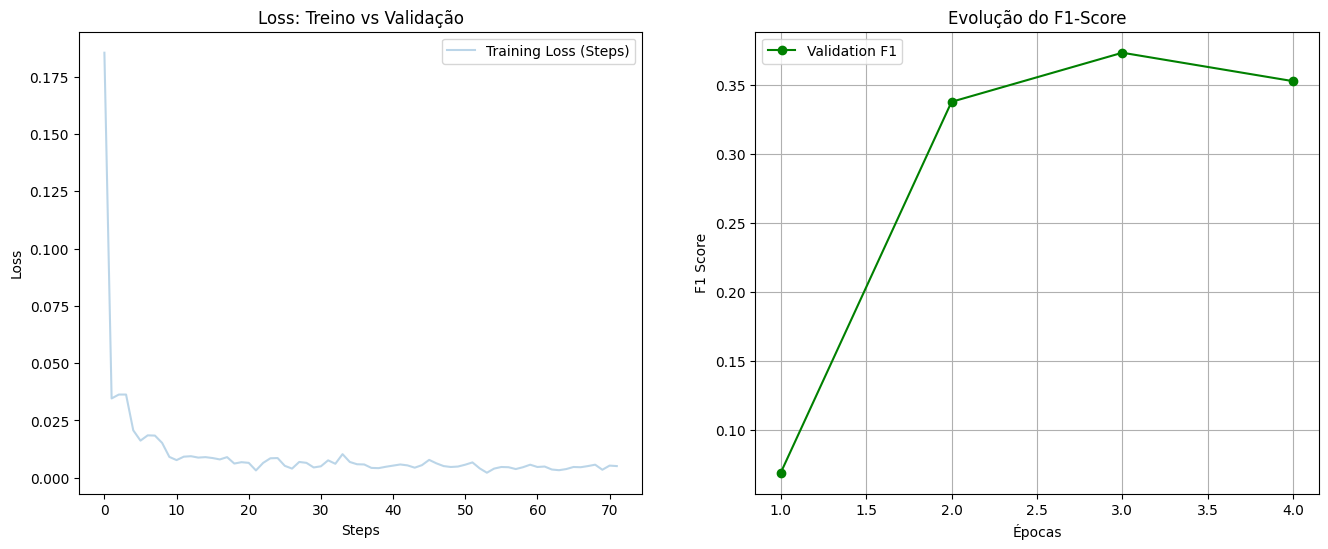

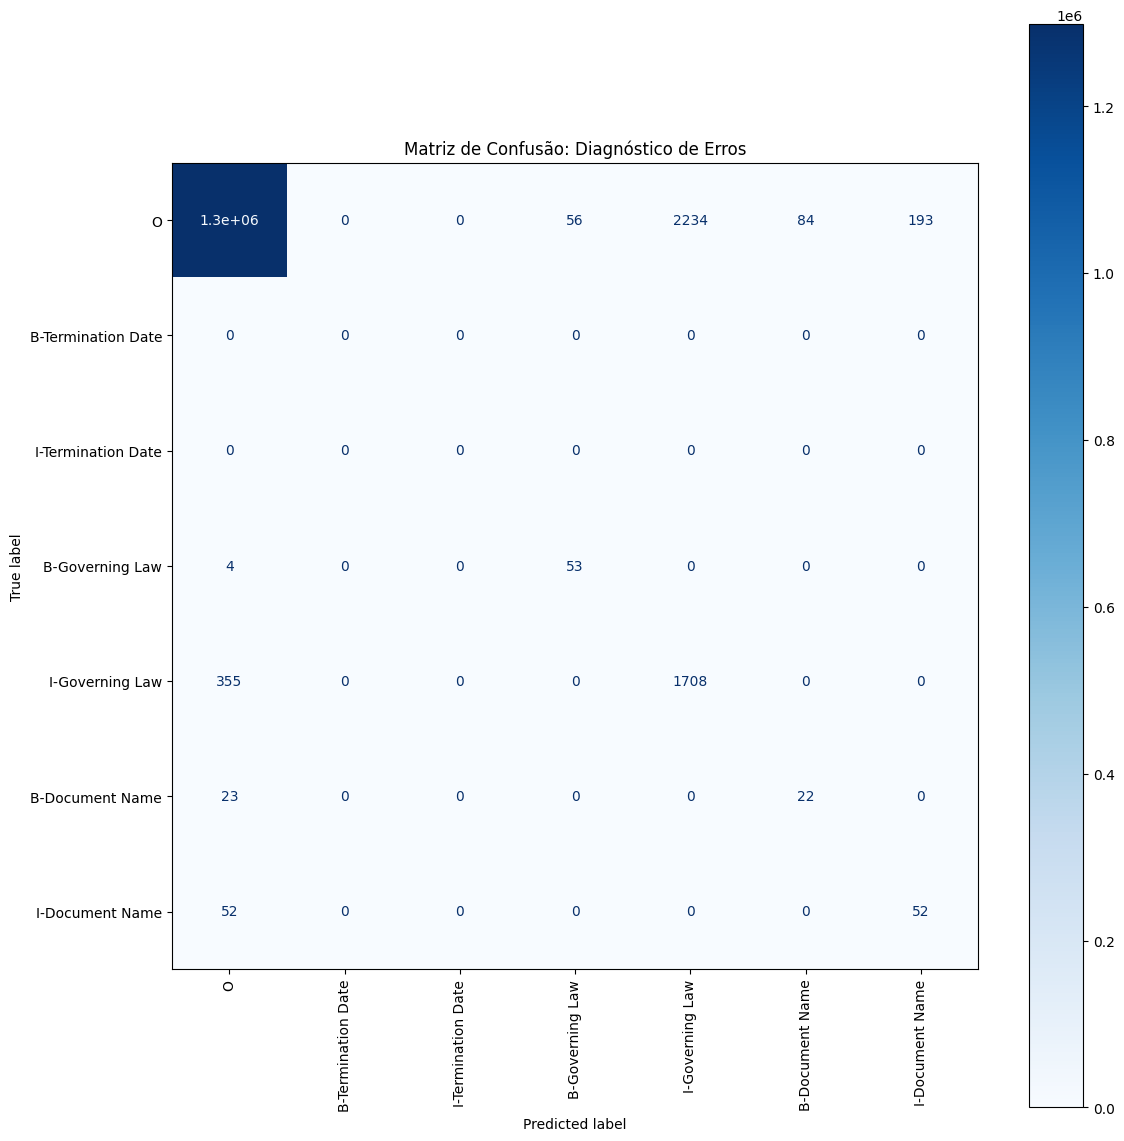

README.md: 0.00B [00:00, ?B/s]

c:\Users\flavi\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\flavi\.cache\huggingface\hub\models--nlpaueb--legal-bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
2025/12/11 00:43:42 WARNING mlflow.utils.requirements_utils: Found torch version (

✅ Modelo versionado e registrado no MLflow Registry!


Successfully registered model 'Legal_Risk_Extractor'.
Created version '1' of model 'Legal_Risk_Extractor'.


In [5]:
# Atualizar args com os melhores parâmetros
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.args.report_to = ["mlflow"]
trainer.args.output_dir = "./legal-bert-ner-production"

mlflow.end_run()

with mlflow.start_run(run_name="Legal-BERT-Final-Build") as run:
    print("Treinando modelo final para produção...")
    trainer.train()

    # --- SALVAR EXPLICITAMENTE PARA INFERÊNCIA LOCAL ---
    local_model_path = "./legal-bert-ner-production/final_model"
    trainer.save_model(local_model_path)
    tokenizer.save_pretrained(local_model_path)
    print(f"Modelo salvo localmente em: {local_model_path}")

    # --- 1. GERAR E SALVAR CURVAS (LOSS & F1) ---
    def plot_metrics(history):
        train_loss = [x['loss'] for x in history if 'loss' in x]
        eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
        eval_f1 = [x['eval_f1'] for x in history if 'eval_f1' in x]
        epochs = range(1, len(eval_loss) + 1)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        ax1.plot(train_loss, label='Training Loss (Steps)', alpha=0.3)
        ax1.set_title('Loss: Treino vs Validação')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Steps')
        ax1.legend()

        ax2.plot(epochs, eval_f1, marker='o', color='green', label='Validation F1')
        ax2.set_title('Evolução do F1-Score')
        ax2.set_ylabel('F1 Score')
        ax2.set_xlabel('Épocas')
        ax2.legend()
        ax2.grid(True)
        return fig

    print("Gerando Curvas de Aprendizado...")
    if len(trainer.state.log_history) > 0:
        metrics_fig = plot_metrics(trainer.state.log_history)
        mlflow.log_figure(metrics_fig, "learning_curves.png")
        print("✅ Gráficos de Loss e F1 salvos no MLflow.")

    # --- 2. DIAGNÓSTICO DE ERRO (Visualização) ---
    print("Gerando Matriz de Confusão...")
    predictions, labels, _ = trainer.predict(test_tokenized)
    predictions = np.argmax(predictions, axis=2)

    true_labels_flat = []
    pred_labels_flat = []

    for i in range(len(labels)):
        for j in range(len(labels[i])):
            if labels[i][j] != -100:
                true_labels_flat.append(id2label[labels[i][j]])
                pred_labels_flat.append(id2label[predictions[i][j]])

    labels_names = list(label2id.keys()) 
    cm = confusion_matrix(true_labels_flat, pred_labels_flat, labels=labels_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)

    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')
    plt.title("Matriz de Confusão: Diagnóstico de Erros")
    plt.tight_layout()
    
    mlflow.log_figure(fig, "confusion_matrix.png")
    plt.show()
    
    # --- 3. REGISTRO DE MODELO (Model Registry) ---
    mlflow.transformers.log_model(
        transformers_model={"model": trainer.model, "tokenizer": tokenizer},
        artifact_path="legal_bert_model",
        registered_model_name="Legal_Risk_Extractor"
    )
    
    print("✅ Modelo versionado e registrado no MLflow Registry!")

## 4. Simulação de Produção (Wrapper de Inferência)

In [6]:
import json

def predict_long_contract(text, model_path):
    """
    Função de Produção: Aceita texto de qualquer tamanho, 
    fatia, processa na GPU e agrega os resultados.
    """
    pipe = pipeline(
        "token-classification", 
        model=model_path, 
        tokenizer=model_path,
        aggregation_strategy="simple", 
        device=0 if torch.cuda.is_available() else -1
    )
    
    results = pipe(text)
    
    structured_data = {}
    for entity in results:
        label = entity['entity_group']
        text_segment = entity['word']
        score = entity['score']
        
        if label not in structured_data:
            structured_data[label] = []
        
        structured_data[label].append({
            "value": text_segment,
            "confidence": float(f"{score:.4f}")
        })
        
    return structured_data

print("\n--- 🚀 Teste de Produção ---")
dummy_contract = """
SECTION 4. TERM AND TERMINATION
This Agreement shall commence on the Effective Date and shall continue in full force 
until December 31, 2028 (the "Termination Date"), unless earlier terminated as provided herein.
...
SECTION 12. GOVERNING LAW
This Agreement shall be governed by and construed in accordance with the laws of the State of Sao Paulo, Brazil.
"""

extracted_data = predict_long_contract(dummy_contract, "./legal-bert-ner-production/final_model")
print(json.dumps(extracted_data, indent=2))


--- 🚀 Teste de Produção ---
{
  "Governing Law": [
    {
      "value": "this agreement shall be governed by and construed in accordance with the laws of the state of sao paulo, brazil.",
      "confidence": 0.7544
    }
  ]
}


## Otimização (Quantização)

In [ ]:
# Célula Extra (Bônus): Otimização para Produção
import torch.quantization
import os

# Carregar modelo na CPU para quantização (Dynamic Quantization roda em CPU)
local_model_path = "./legal-bert-ner-production/final_model"
model_cpu = AutoModelForTokenClassification.from_pretrained(local_model_path).to("cpu")

quantized_model = torch.quantization.quantize_dynamic(
    model_cpu, {torch.nn.Linear}, dtype=torch.qint8
)

# Comparação de Tamanho
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print("Modelo Original (FP32):")
print_size_of_model(model_cpu)

print("Modelo Quantizado (INT8):")
print_size_of_model(quantized_model)
print("🚀 Redução de custo de armazenamento/memória para deploy!")